In [2]:
!pip install segmentation_models_pytorch
!pip install albumentations
!pip install timm
!pip install wandb

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 52.1 MB/s eta 0:00:00:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=a5383b3320240cd87797c481c8b43d3822c2d19871ae3d023947e6b632da7598
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=69327c332a74674a0708806da3f960946ded2800274cb209157ab3283226eed0
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-p

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2 # np.array -> torch.tensor
import os
from tqdm import tqdm
from glob import glob
from torchvision.datasets import VOCSegmentation
import torch.nn.functional as F
import timm

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_api_key = user_secrets.get_secret("wandb-api-key")

import wandb
wandb.login(key=wandb_api_key)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
import cv2
import numpy as np
from torchvision.datasets import VOCSegmentation

cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)


VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]


VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]


class PascalVOCSearchDataset(VOCSegmentation):
    def __init__(self, root="~/data/pascal_voc", image_set="train", download=True, transform=None,year=None):
        super().__init__(root=root, image_set=image_set, download=download, transform=transform,year=year)

    @staticmethod
    def _convert_to_segmentation_mask(mask):
        # This function converts a mask from the Pascal VOC format to the format required by AutoAlbument.
        #
        # Pascal VOC uses an RGB image to encode the segmentation mask for that image. RGB values of a pixel
        # encode the pixel's class.
        #
        # AutoAlbument requires a segmentation mask to be a NumPy array with the shape [height, width, num_classes].
        # Each channel in this mask should encode values for a single class. Pixel in a mask channel should have
        # a value of 1.0 if the pixel of the image belongs to this class and 0.0 otherwise.
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)), dtype=np.float32)
        for label_index, label in enumerate(VOC_COLORMAP):
            segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
        return segmentation_mask

    def __getitem__(self, index):
        image = cv2.imread(self.images[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[index])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self._convert_to_segmentation_mask(mask)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        return image, mask.argmax(dim=2).squeeze()

In [5]:
trainsize = 256

train_transform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.Blur(),
    A.Sharpen(),
    A.RGBShift(),
    A.CoarseDropout(min_holes=1, max_holes=5, min_height=25, min_width=25, max_height=25, max_width=25, fill_value=0),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])

test_trainsform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(), # numpy.array -> torch.tensor (B, 3, H, W)
])

In [6]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        
    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
    
unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

100%|██████████| 1999639040/1999639040 [00:07<00:00, 260708723.89it/s]


Extracting /root/data/pascal_voc/VOCtrainval_11-May-2012.tar to /root/data/pascal_voc


100%|██████████| 1765686784/1765686784 [00:08<00:00, 215946525.57it/s]


Extracting /root/data/pascal_voc/VOCtrainval_25-May-2011.tar to /root/data/pascal_voc


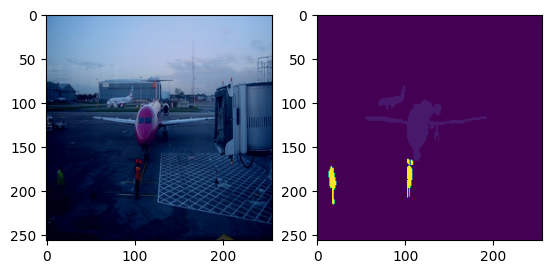

In [8]:
train_dataset = PascalVOCSearchDataset(image_set="trainval", download=True, transform=train_transform,year="2012")
test_dataset = PascalVOCSearchDataset(image_set="val", download=True, transform=test_trainsform,year="2011")

image, mask = train_dataset[0]
plt.subplot(1, 2, 1)
plt.imshow(unorm(image).permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.show()

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [11]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()

        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

In [12]:
#model UNet
# class DoubleConv(in_channels, out_channels):
#     return nn.Sequential(
#         nn.Conv2d(in_channels, out_channels, 3, 1, 1),
#         nn.ReLU(),
#         nn.Conv2d(out_channels, out_channels, 3, 1, 1),
#         nn.ReLU()
#     )
    
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()

        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

class Unet_Resnet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.n_classes = n_classes
        self.encoder = timm.create_model("resnet50", pretrained=True, features_only=True)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear")
        self.block_neck = DoubleConv(2048, 1024)
        self.block_up1 = DoubleConv(1024+1024, 512)
        self.block_up2 = DoubleConv(512+512, 256)
        self.block_up3 = DoubleConv(256+256, 128)
        self.block_up4 = DoubleConv(128+64, 64)
        self.conv_cls = nn.Conv2d(64, self.n_classes, 1)

    def forward(self, x):
        # skip connections của resnet50
        x1, x2, x3, x4, x5 = self.encoder(x)
        # x1 (B, 64, 128, 128) size/2
        # x2 (B, 256, 64, 64) size/4
        # x3 (B, 512, 32, 32) size/16
        # x4 (B, 1024, 16, 16) size/32
        # x5 (B, 2048, 8, 8) size/64

        # bottleneck
        x = self.block_neck(x5) # x (B, 1024, 8, 8)

        # concat skip connections then halve the features channels
        x = torch.cat([x4, self.upsample(x)], dim=1) 
        x = self.block_up1(x)
        x = torch.cat([x3, self.upsample(x)], dim=1)
        x = self.block_up2(x)
        x = torch.cat([x2, self.upsample(x)], dim=1)
        x = self.block_up3(x)
        x = torch.cat([x1, self.upsample(x)], dim=1)
        x = self.block_up4(x)
        # classifier
        x = self.conv_cls(x) #size/2
        # scaling to return to the original size
        x = self.upsample(x)
        return x

In [16]:
unet_res = Unet_Resnet(21).to(device)
unet_res = nn.DataParallel(unet_res)
unet_res.load_state_dict(torch.load(
    "/kaggle/input/30epochs/pytorch/default/1/unet-res_epoch30.pth", 
    map_location=torch.device('cpu'),
    weights_only = True
))

<All keys matched successfully>

In [17]:
x = torch.rand(2, 3, 256, 256)
y = unet_res(x.to(device))
print(y.shape)

torch.Size([2, 21, 256, 256])


In [18]:
#load data
batch_size = 16
n_workers = os.cpu_count()
print("num_workers =", n_workers)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=n_workers)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=n_workers)

num_workers = 4


In [19]:
len(trainloader), len(testloader)

(183, 70)

In [21]:
#loss
criterion = nn.CrossEntropyLoss()

#optimizer
optimizer = torch.optim.Adam(unet_res.parameters(), lr=1e-4)
n_eps = 30

In [22]:
def save_model(model, file_path):
    file_path = file_path + '.pth'
    dir_name = os.path.dirname(file_path)
    if dir_name and not os.path.exists(dir_name):
        os.makedirs(dir_name)
    
    # Save
    torch.save(model.state_dict(), file_path)
    print(f"Model is saved to: {file_path}")

In [23]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, save_path=None, epochs=10, wandb_writer=None):
    best_loss = float('inf')

    train_losses = []
    val_losses = []
    train_accuracy = []
    val_accuracy = []
    model.to(device)
    model.train()
    for epoch in range(epochs):
        train_loss, train_acc = 0, 0

        for images, masks in tqdm(train_loader, unit='batch', desc=f'Training [{epoch+1}/{epochs}]'):
            images, masks = images.to(device), masks.to(device)
            
            # with torch.cuda.amp.autocast(enabled=False):
            mask_logits = model(images) # (B, C, H, W)

            # Resize to original size of mask
            # mask_logits = F.interpolate(mask_logits, size=(1024, 2048), mode='bilinear', align_corners=False)

            # Loss
            loss = criterion(mask_logits, masks)
            train_loss += loss.item()

            # Update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # scaler.scale(loss).backward()
            # scaler.step(optimizer)
            # scaler.update()

            # Calculate accuracy over pixel
            mask_pred = torch.argmax(mask_logits, dim = 1)
            mask_pred[masks == -1] = -1
            
            valid_mask = masks != -1
            acc_per_batch = torch.eq(mask_pred[valid_mask], masks[valid_mask]).sum().item()
            train_acc += (acc_per_batch / masks.numel())
        avg_train_loss = train_loss / len(train_loader)
        avg_train_acc = train_acc / len(train_loader)
        
        print(f'---> Train loss: {avg_train_loss:.4f}')
        print(f'---> Train acc: {avg_train_acc:.4f}')
        if wandb_writer is not None:    
            wandb_writer.log({"train_loss": avg_train_loss, "train_acc": avg_train_acc, "epoch": epoch + 1})

        train_losses.append(avg_train_loss)
        train_accuracy.append(avg_train_acc)
        
        # Validate
        val_loss, val_acc = 0,0
        model.cuda().eval()
        with torch.inference_mode():
            for images, masks in tqdm(val_loader, unit='batch', desc=f'Validate [{epoch+1}/{epochs}]'):
                images, masks = images.to(device).cuda(), masks.to(device).cuda()
                
                # with torch.cuda.amp.autocast(enabled=False):
                mask_logits = model(images)
                # mask_logits = F.interpolate(mask_logits, size=(1024, 2048), mode='bilinear', align_corners=False)
                loss = criterion(mask_logits, masks)
                val_loss += loss.item()
                
                mask_pred = torch.argmax(mask_logits, dim = 1)
                mask_pred[masks == -1] = -1
                
                valid_mask = masks != -1
                acc_per_batch = torch.eq(mask_pred[valid_mask], masks[valid_mask]).sum().item()
                val_acc += (acc_per_batch / masks.numel())
        avg_val_loss = val_loss / len(val_loader)
        avg_val_acc = val_acc / len(val_loader)
        
        print(f'---> Valid loss: {avg_val_loss:.4f}')
        print(f'---> Valid acc: {avg_val_acc:.4f}')
        if wandb_writer is not None:
            wandb_writer.log({"val_loss": avg_val_loss, "val_acc": avg_val_acc, "epoch": epoch + 1})
        
        val_losses.append(avg_val_loss)
        val_accuracy.append(avg_val_acc)
        
        if save_path is not None:
            if avg_val_loss < best_loss:
                best_loss = avg_val_loss
                save_model(model, save_path + f'_epoch{epoch+1}')
                if wandb_writer is not None:
                    wandb_writer.save(f"{save_path}_epoch{epoch+1}.pth")
    # if wandb_writer is not None:
    #     wandb_writer.finish()
    return train_losses, val_losses, train_accuracy, val_accuracy

In [24]:
# Initialize W&B project
unet_train_wan = wandb.init(
    project="image-segmentation",  
    name="unet-tuning",     
    config={
        "batch_size": trainloader.batch_size,
        "learning_rate": optimizer.defaults['lr'],
        "weight_decay": optimizer.defaults['weight_decay'],
        "architecture": unet_res.__class__.__name__,
    }
)

wandb: Currently logged in as: minh3103 (minh3103-vietnam-national-university-hanoi). Use `wandb login --relogin` to force relogin


In [25]:
save_path = '/kaggle/working/models/unet-res'
train_losses, val_losses, train_accuracy, val_accuracy = train_model(unet_res, trainloader, testloader, 
                                                                     criterion, optimizer, device, 
                                                                     save_path, epochs=n_eps,
                                                                     wandb_writer = unet_train_wan)

Training [1/30]: 100%|██████████| 183/183 [03:20<00:00,  1.10s/batch]


---> Train loss: 1.1750
---> Train acc: 0.7433


Validate [1/30]: 100%|██████████| 70/70 [01:13<00:00,  1.05s/batch]


---> Valid loss: 1.0525
---> Valid acc: 0.7566


wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model is saved to: /kaggle/working/models/unet-res_epoch1.pth


Training [2/30]: 100%|██████████| 183/183 [03:20<00:00,  1.10s/batch]


---> Train loss: 0.9199
---> Train acc: 0.7691


Validate [2/30]: 100%|██████████| 70/70 [01:13<00:00,  1.05s/batch]


---> Valid loss: 0.8349
---> Valid acc: 0.7718
Model is saved to: /kaggle/working/models/unet-res_epoch2.pth


Training [3/30]: 100%|██████████| 183/183 [03:21<00:00,  1.10s/batch]


---> Train loss: 0.7358
---> Train acc: 0.8016


Validate [3/30]: 100%|██████████| 70/70 [01:12<00:00,  1.04s/batch]


---> Valid loss: 0.6472
---> Valid acc: 0.8128
Model is saved to: /kaggle/working/models/unet-res_epoch3.pth


Training [4/30]: 100%|██████████| 183/183 [03:19<00:00,  1.09s/batch]


---> Train loss: 0.5996
---> Train acc: 0.8246


Validate [4/30]: 100%|██████████| 70/70 [01:12<00:00,  1.04s/batch]


---> Valid loss: 0.4903
---> Valid acc: 0.8512
Model is saved to: /kaggle/working/models/unet-res_epoch4.pth


Training [5/30]: 100%|██████████| 183/183 [03:20<00:00,  1.09s/batch]


---> Train loss: 0.5151
---> Train acc: 0.8469


Validate [5/30]: 100%|██████████| 70/70 [01:12<00:00,  1.04s/batch]


---> Valid loss: 0.7172
---> Valid acc: 0.7428


Training [6/30]: 100%|██████████| 183/183 [03:19<00:00,  1.09s/batch]


---> Train loss: 0.4581
---> Train acc: 0.8665


Validate [6/30]: 100%|██████████| 70/70 [01:13<00:00,  1.05s/batch]


---> Valid loss: 0.3304
---> Valid acc: 0.8999
Model is saved to: /kaggle/working/models/unet-res_epoch6.pth


Training [7/30]: 100%|██████████| 183/183 [03:19<00:00,  1.09s/batch]


---> Train loss: 0.3518
---> Train acc: 0.8939


Validate [7/30]: 100%|██████████| 70/70 [01:13<00:00,  1.05s/batch]


---> Valid loss: 0.2933
---> Valid acc: 0.9110
Model is saved to: /kaggle/working/models/unet-res_epoch7.pth


Training [8/30]: 100%|██████████| 183/183 [03:19<00:00,  1.09s/batch]


---> Train loss: 0.3183
---> Train acc: 0.9027


Validate [8/30]: 100%|██████████| 70/70 [01:13<00:00,  1.05s/batch]


---> Valid loss: 0.2563
---> Valid acc: 0.9180
Model is saved to: /kaggle/working/models/unet-res_epoch8.pth


Training [9/30]: 100%|██████████| 183/183 [03:20<00:00,  1.09s/batch]


---> Train loss: 0.2956
---> Train acc: 0.9088


Validate [9/30]: 100%|██████████| 70/70 [01:13<00:00,  1.05s/batch]


---> Valid loss: 0.2520
---> Valid acc: 0.9200
Model is saved to: /kaggle/working/models/unet-res_epoch9.pth


Training [10/30]: 100%|██████████| 183/183 [03:20<00:00,  1.10s/batch]


---> Train loss: 0.2811
---> Train acc: 0.9120


Validate [10/30]: 100%|██████████| 70/70 [01:13<00:00,  1.05s/batch]


---> Valid loss: 0.2149
---> Valid acc: 0.9286
Model is saved to: /kaggle/working/models/unet-res_epoch10.pth


Training [11/30]: 100%|██████████| 183/183 [03:20<00:00,  1.10s/batch]


---> Train loss: 0.2305
---> Train acc: 0.9246


Validate [11/30]: 100%|██████████| 70/70 [01:13<00:00,  1.04s/batch]


---> Valid loss: 0.1818
---> Valid acc: 0.9365
Model is saved to: /kaggle/working/models/unet-res_epoch11.pth


Training [12/30]: 100%|██████████| 183/183 [03:20<00:00,  1.09s/batch]


---> Train loss: 0.2219
---> Train acc: 0.9272


Validate [12/30]: 100%|██████████| 70/70 [01:12<00:00,  1.04s/batch]


---> Valid loss: 0.1835
---> Valid acc: 0.9392


Training [13/30]: 100%|██████████| 183/183 [03:20<00:00,  1.10s/batch]


---> Train loss: 0.2041
---> Train acc: 0.9313


Validate [13/30]: 100%|██████████| 70/70 [01:15<00:00,  1.07s/batch]


---> Valid loss: 0.1678
---> Valid acc: 0.9411
Model is saved to: /kaggle/working/models/unet-res_epoch13.pth


Training [14/30]: 100%|██████████| 183/183 [03:23<00:00,  1.11s/batch]


---> Train loss: 0.1945
---> Train acc: 0.9340


Validate [14/30]: 100%|██████████| 70/70 [01:14<00:00,  1.06s/batch]


---> Valid loss: 0.1648
---> Valid acc: 0.9426
Model is saved to: /kaggle/working/models/unet-res_epoch14.pth


Training [15/30]: 100%|██████████| 183/183 [03:23<00:00,  1.11s/batch]


---> Train loss: 0.1924
---> Train acc: 0.9354


Validate [15/30]: 100%|██████████| 70/70 [01:14<00:00,  1.07s/batch]


---> Valid loss: 0.1453
---> Valid acc: 0.9483
Model is saved to: /kaggle/working/models/unet-res_epoch15.pth


Training [16/30]: 100%|██████████| 183/183 [03:24<00:00,  1.12s/batch]


---> Train loss: 0.1890
---> Train acc: 0.9370


Validate [16/30]: 100%|██████████| 70/70 [01:14<00:00,  1.06s/batch]


---> Valid loss: 0.1483
---> Valid acc: 0.9473


Training [17/30]: 100%|██████████| 183/183 [03:22<00:00,  1.11s/batch]


---> Train loss: 0.1711
---> Train acc: 0.9419


Validate [17/30]: 100%|██████████| 70/70 [01:15<00:00,  1.07s/batch]


---> Valid loss: 0.1361
---> Valid acc: 0.9509
Model is saved to: /kaggle/working/models/unet-res_epoch17.pth


Training [18/30]: 100%|██████████| 183/183 [03:22<00:00,  1.11s/batch]


---> Train loss: 0.2027
---> Train acc: 0.9339


Validate [18/30]: 100%|██████████| 70/70 [01:14<00:00,  1.07s/batch]


---> Valid loss: 0.1674
---> Valid acc: 0.9452


Training [19/30]: 100%|██████████| 183/183 [03:22<00:00,  1.11s/batch]


---> Train loss: 0.1838
---> Train acc: 0.9387


Validate [19/30]: 100%|██████████| 70/70 [01:15<00:00,  1.07s/batch]


---> Valid loss: 0.1405
---> Valid acc: 0.9509


Training [20/30]: 100%|██████████| 183/183 [03:23<00:00,  1.11s/batch]


---> Train loss: 0.1583
---> Train acc: 0.9459


Validate [20/30]: 100%|██████████| 70/70 [01:14<00:00,  1.06s/batch]


---> Valid loss: 0.1167
---> Valid acc: 0.9579
Model is saved to: /kaggle/working/models/unet-res_epoch20.pth


Training [21/30]: 100%|██████████| 183/183 [03:23<00:00,  1.11s/batch]


---> Train loss: 0.1583
---> Train acc: 0.9454


Validate [21/30]: 100%|██████████| 70/70 [01:14<00:00,  1.07s/batch]


---> Valid loss: 0.1318
---> Valid acc: 0.9523


Training [22/30]: 100%|██████████| 183/183 [03:24<00:00,  1.12s/batch]


---> Train loss: 0.1873
---> Train acc: 0.9369


Validate [22/30]: 100%|██████████| 70/70 [01:14<00:00,  1.06s/batch]


---> Valid loss: 0.1216
---> Valid acc: 0.9556


Training [23/30]: 100%|██████████| 183/183 [03:23<00:00,  1.11s/batch]


---> Train loss: 0.1437
---> Train acc: 0.9493


Validate [23/30]: 100%|██████████| 70/70 [01:14<00:00,  1.07s/batch]


---> Valid loss: 0.1125
---> Valid acc: 0.9591
Model is saved to: /kaggle/working/models/unet-res_epoch23.pth


Training [24/30]: 100%|██████████| 183/183 [03:24<00:00,  1.12s/batch]


---> Train loss: 0.1284
---> Train acc: 0.9541


Validate [24/30]: 100%|██████████| 70/70 [01:15<00:00,  1.07s/batch]


---> Valid loss: 0.1086
---> Valid acc: 0.9604
Model is saved to: /kaggle/working/models/unet-res_epoch24.pth


Training [25/30]: 100%|██████████| 183/183 [03:23<00:00,  1.11s/batch]


---> Train loss: 0.1265
---> Train acc: 0.9545


Validate [25/30]: 100%|██████████| 70/70 [01:14<00:00,  1.06s/batch]


---> Valid loss: 0.1036
---> Valid acc: 0.9616
Model is saved to: /kaggle/working/models/unet-res_epoch25.pth


Training [26/30]: 100%|██████████| 183/183 [03:22<00:00,  1.11s/batch]


---> Train loss: 0.1228
---> Train acc: 0.9558


Validate [26/30]: 100%|██████████| 70/70 [01:15<00:00,  1.07s/batch]


---> Valid loss: 0.0981
---> Valid acc: 0.9638
Model is saved to: /kaggle/working/models/unet-res_epoch26.pth


Training [27/30]: 100%|██████████| 183/183 [03:22<00:00,  1.11s/batch]


---> Train loss: 0.1399
---> Train acc: 0.9515


Validate [27/30]: 100%|██████████| 70/70 [01:14<00:00,  1.06s/batch]


---> Valid loss: 0.1505
---> Valid acc: 0.9501


Training [28/30]: 100%|██████████| 183/183 [03:21<00:00,  1.10s/batch]


---> Train loss: 0.1394
---> Train acc: 0.9517


Validate [28/30]: 100%|██████████| 70/70 [01:14<00:00,  1.07s/batch]


---> Valid loss: 0.1164
---> Valid acc: 0.9585


Training [29/30]: 100%|██████████| 183/183 [03:23<00:00,  1.11s/batch]


---> Train loss: 0.1312
---> Train acc: 0.9536


Validate [29/30]: 100%|██████████| 70/70 [01:14<00:00,  1.06s/batch]


---> Valid loss: 0.0962
---> Valid acc: 0.9643
Model is saved to: /kaggle/working/models/unet-res_epoch29.pth


Training [30/30]: 100%|██████████| 183/183 [03:23<00:00,  1.11s/batch]


---> Train loss: 0.1277
---> Train acc: 0.9548


Validate [30/30]: 100%|██████████| 70/70 [01:14<00:00,  1.06s/batch]


---> Valid loss: 0.0960
---> Valid acc: 0.9642
Model is saved to: /kaggle/working/models/unet-res_epoch30.pth


background
person


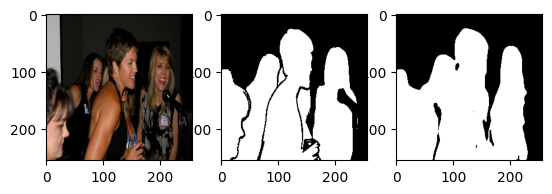

In [25]:
#predict
import random
id = random.randint(0,test_dataset.__len__()-1)
with torch.no_grad():
    unet_res.eval()
    x, y = test_dataset.__getitem__(id)
    y_predict = unet_res(x.unsqueeze(0).to(device)).argmax(dim=1).squeeze().cpu().numpy()
    for i in np.unique(y_predict).tolist():
        print(VOC_CLASSES[i])
    color_mask_predict = np.zeros((*y_predict.shape, 3))
    for i, color in enumerate(VOC_COLORMAP):
        color_mask_predict[y_predict==i] = np.array(color)
    color_mask = np.zeros((*y_predict.shape, 3))
    for i, color in enumerate(VOC_COLORMAP):
        color_mask[y==i] = np.array(color)
    plt.subplot(1,3,1)
    plt.imshow(unorm(x).permute(1, 2, 0))
    plt.subplot(1,3,2)
    plt.imshow(color_mask)
    plt.subplot(1,3,3)
    plt.imshow(color_mask_predict)
    plt.show()